In [4]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as st
# import pymc3 as pm
import seaborn as sns
import wtascripts.wta_helpers as wta_helpers

# enables inline plots, without it plots don't show up in the notebook
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
# %config InlineBackend.figure_format = 'png'
# mpl.rcParams['figure.dpi']= 300

In [5]:
# Sklearn specific imports
from sklearn.preprocessing import StandardScaler, LabelBinarizer, MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn import metrics

In [6]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 25)
pd.set_option('display.precision', 3)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
np.set_printoptions(suppress=True)

In [7]:
# Load then clean dataset
df = wta_helpers.load_raw_df()
df = wta_helpers.clean_raw_df(df)

## Plan of Action
* Use multi-label binarizer :  fee column
* Use label binarizer : region
* Probably remove votes or countreports due to collinearity. Which one is better? I think votes is bad too due to direct tie to trail
  * A better model wouldn't have votes or count of reports - because those are not trail features

#### Questions/ Flaws:
* With MLB I'm not accounting for parks that have multiple fees . I could simplify by saying fee or no fee? 

### Preprocessing

In [278]:
onehot_feats = ['Wildflowers/Meadows', 'Ridges/passes',
'Wildlife','Waterfalls','Old growth','Summits','Good for kids','Dogs allowed on leash',
'Fall foliage','Lakes','Rivers','Coast','Mountain views','Established campsites',]
# Not used: lat, long, subregion, lengthtype

# cont_feats = ['votes', 'countreports', 'length', 'gain', 'hpoint']
cont_feats = ['votes', 'length', 'gain', 'hpoint']
# cont_feats = ['length', 'gain', 'hpoint']



oh_cols = df[onehot_feats]

#Standardize the non one-hot encoding variables into XS
s = StandardScaler()
XS = s.fit_transform(df[cont_feats])
#print(oh_cols)
# combine with the one hot encoding variables

/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [279]:
# multilabelbinarizer for 'fees' column
mlb = MultiLabelBinarizer()
fees_processed = mlb.fit_transform(df['fee'].str.replace(", ",",").str.split(","))

In [280]:
# labelbinarizer for 'region' column
lb = LabelBinarizer()
region_processed = lb.fit_transform(df['region'])

In [281]:
X = np.concatenate([XS, oh_cols, fees_processed, region_processed], axis=1) ## All features
# X = np.concatenate([oh_cols, fees_processed, region_processed], axis=1) ## Remove continuous features
# X = np.concatenate([XS], axis=1) ## Only continuous features


y = df['rating']

In [301]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

reg = LinearRegression()

reg.fit(X_train, y_train)

print("intercept:",reg.intercept_)
print("coefficients,",reg.coef_)

y_pred = reg.predict(X_test)

print("RMSE:", np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print("MSE:", metrics.mean_squared_error(y_test, y_pred))
print("R^2:", reg.score(X_test, y_test))

intercept: 3.2790933950763597
coefficients, [ 0.14181351 -0.02231833  0.01275482  0.09712149  0.03898132 -0.00184221
 -0.08526376  0.26632051 -0.00509786  0.26649756  0.17386497  0.00805094
  0.05462608  0.09158234  0.04271365  0.34374108  0.10395673  0.03793504
 -0.11559894  0.08765506 -0.01062516 -0.08163426 -0.10875154 -1.43075487
  0.         -0.14152261 -0.03276484 -0.00149849  0.09090343 -0.16197509
 -0.05048266  0.03507065  0.12619044  0.08844586 -0.06222343 -0.1467043
  0.11503842]
RMSE: 0.7204911215369247
MSE: 0.5191074562135356
R^2: 0.07714570024174039


Sort coefficients from greatest value to least. This should give an idea of what heavily affects the model.

In [283]:
newlist = cont_feats + onehot_feats + list(mlb.classes_) + list(lb.classes_) ## Everything
# newlist = onehot_feats + list(mlb.classes_) + list(lb.classes_) ## remove continuous features
# newlist = cont_feats ## only continuous features


#newlist
#len(newlist)

import pprint
hold = sorted(zip(newlist, reg.coef_), key=lambda x: x[1], reverse=True)
pprint.pprint(hold)

[('Coast', 0.35029581493784656),
 ('Sno-Parks Permit', 0.2747099387613753),
 ('Waterfalls', 0.2475273511616691),
 ('National Monument Fee', 0.24120348487439833),
 ('Summits', 0.22289980292272776),
 ('National Park Pass', 0.19598109800830543),
 ('Southwest Washington', 0.17729740618141268),
 ('Northwest Forest Pass', 0.17137954145714115),
 ('Eastern Washington', 0.15364710614339627),
 ('Good for kids', 0.15157981464597428),
 ('Mountain views', 0.14262540838936788),
 ('votes', 0.14117059694499878),
 ('None', 0.11987259730555216),
 ('Puget Sound and Islands', 0.11864051857364297),
 ('Central Washington', 0.10835266177479926),
 ('Discover Pass', 0.08676480926851013),
 ('Olympic Peninsula', 0.08036170408035301),
 ('Ridges/passes', 0.07784840586648713),
 ('hpoint', 0.06228434004542731),
 ('Wildflowers/Meadows', 0.04813273365381176),
 ('Fall foliage', 0.04140797969805887),
 ('Old growth', 0.0397138076721945),
 ('Established campsites', 0.03372138225054155),
 ('Rivers', 0.017075618481476623),


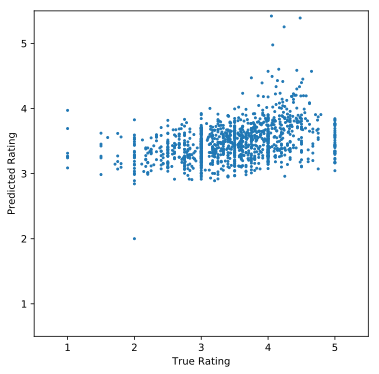

In [303]:
plt.figure(figsize = (6, 6))
plt.scatter(df['rating'], reg.predict(X), s=4, vmin=1, vmax=5)
plt.xlabel("True Rating")
plt.ylabel("Predicted Rating")
plt.ylim(0.5, 5.5)
plt.xlim(0.5, 5.5)
plt.show();

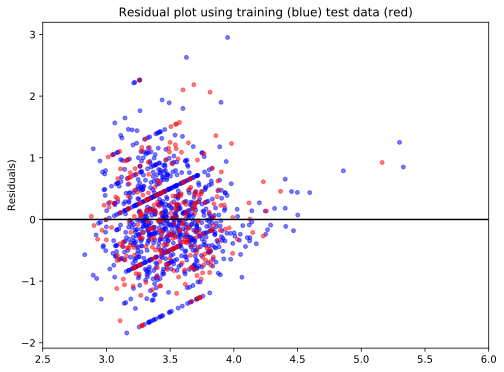

In [297]:
plt.figure(figsize = (8,6))
plt.scatter(reg.predict(X_train), reg.predict(X_train) - y_train, c='b', s=15, alpha=0.5)
plt.scatter(reg.predict(X_test), reg.predict(X_test) - y_test, c='r', s=15, alpha=0.5)
plt.hlines(y=0, xmin=0, xmax=50)
plt.xlim(2.5,6)
plt.title("Residual plot using training (blue) test data (red)")
plt.ylabel("Residuals)");

In [193]:
df.groupby(by = 'region').agg(['median', 'count']).sort_values(('rating','median'),ascending=False)

votes       rating       length           gain        \
                        median count median count median count   median count   
region                                                                          
Puget Sound and Islands  5.000    90  3.765    90  3.950    90  300.000    90   
North Cascades           8.000   173  3.640   173  8.200   173 2000.000   173   
Mount Rainier Area       7.000   122  3.610   122  7.000   122 1350.000   122   
Olympic Peninsula        7.000   148  3.595   148  6.800   148 1043.500   148   
Central Cascades         7.000   133  3.560   133  8.600   133 1800.000   133   
Snoqualmie Region        8.500   150  3.560   150  8.000   150 2100.000   150   
Eastern Washington       4.000    49  3.500    49  7.000    49 1000.000    49   
Southwest Washington     4.000    68  3.500    68  4.700    68  825.000    68   
Central Washington       6.000    39  3.250    39  6.000    39  500.000    39   
South Cascades           6.000   133  3.250   133  8.000   133 1400.000   133   
Issaquah Alps            6.000    45  3.140    45  4.600    45 1127.000    45   

                          hpoint          lat           long        \
                          median count median count   median count   
region                                                               
Puget Sound and Islands  405.000    90 47.859    90 -122.400    90   
North Cascades          5392.000   173 48.537   173 -121.324   173   
Mount Rainier Area      5700.000   122 46.902   122 -121.644   122   
Olympic Peninsula       2500.000   148 47.856   148 -123.294   148   
Central Cascades        5065.000   133 47.788   133 -120.917   133   
Snoqualmie Region       4769.000   150 47.421   150 -121.394   150   
Eastern Washington      4800.000    49 47.886    49 -117.526    49   
Southwest Washington    1900.000    68 45.781    68 -122.004    68   
Central Washington      1500.000    39 46.937    39 -119.494    39   
South Cascades          4948.000   133 46.309   133 -121.763   133   
Issaquah Alps           1830.000    45 47.521    45 -122.008    45   

                        countreports       Wildflowers/Meadows        \
                              median count              median count   
region                                                                 
Puget Sound and Islands       27.000    90                   0    90   
North Cascades                64.000   173                   1   173   
Mount Rainier Area            55.000   122                   1   122   
Olympic Peninsula             37.000   148                   0   148   
Central Cascades              57.000   133                   1   133   
Snoqualmie Region            108.500   150                   1   150   
Eastern Washington            11.000    49                   1    49   
Southwest Washington          11.000    68                   0    68   
Central Washington            30.000    39                   1    39   
South Cascades                16.000   133                   0   133   
Issaquah Alps                 66.000    45                   1    45   

                        Mountain views       Dogs allowed on leash        \
                                median count                median count   
region                                                                     
Puget Sound and Islands              0    90                     1    90   
North Cascades                       1   173                     0   173   
Mount Rainier Area                   1   122                     0   122   
Olympic Peninsula                    1   148                     0   148   
Central Cascades                     1   133                     1   133   
Snoqualmie Region                    1   150                     1   150   
Eastern Washington                   1    49                     1    49   
Southwest Washington                 0    68                     1    68   
Central Washington                   0    39                    

In [141]:
df.describe()

,votes,rating,length,gain,hpoint,lat,long,countreports,Wildflowers/Meadows,Mountain views,Dogs allowed on leash,Established campsites,Waterfalls,Good for kids,Fall foliage,Ridges/passes,Wildlife,Old growth,Summits,Lakes,Rivers,Coast
count,1150.000,1150.000,1150.000,1150.000,1150.000,1150.000,1150.000,1150.000,1150.000,1150.000,1150.000,1150.000,1150.000,1150.000,1150.000,1150.000,1150.000,1150.000,1150.000,1150.000,1150.000,1150.000
mean,12.803,3.491,8.190,1658.423,3862.960,47.445,-121.569,104.282,0.525,0.642,0.515,0.250,0.169,0.361,0.246,0.272,0.395,0.313,0.229,0.334,0.296,0.045
std,23.843,0.739,7.281,1570.078,2219.094,0.816,1.235,187.523,0.500,0.480,0.500,0.433,0.375,0.480,0.431,0.445,0.489,0.464,0.420,0.472,0.457,0.208
min,1.000,1.000,0.160,10.000,10.000,45.560,-124.683,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,4.000,3.000,4.000,500.000,1900.000,46.898,-122.115,15.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
50%,6.000,3.500,7.000,1300.000,4200.000,47.516,-121.628,41.000,1.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
75%,12.000,4.000,10.230,2500.000,5700.000,47.977,-121.092,107.000,1.000,1.000,1.000,0.000,0.000,1.000,0.000,1.000,1.000,1.000,0.000,1.000,1.000,0.000
max,294.000,5.000,117.000,26351.000,12276.000,48.995,-115.936,1697.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000


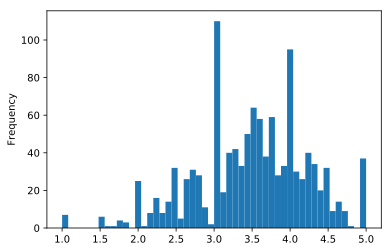

In [115]:
df.rating.plot.hist(50)

In [ ]:
# votes, count of tripreports, mountains, waterfall, summits, then hpoint, then ridges/passes

In [ ]:
sns.pairplot(df[(df.votes > 3) & (df.length < 60) & (df.hpoint < 9000)],
             x_vars=['votes','length','gain','hpoint','countreports'],
             y_vars='rating')

In [ ]:
# votes and count reports are highly correlated
plt.scatter(df['votes'], df['countreports']);

In [ ]:
cont_cols= ['votes', 'countreports', 'length', 'gain', 'hpoint', 'Wildflowers/Meadows', 'Ridges/passes',
            'Wildlife','Waterfalls','Old growth','Summits','Good for kids','Dogs allowed on leash',
            'Fall foliage','Lakes','Rivers','Coast','Mountain views','Established campsites',]

In [ ]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics

cont_cols = ['votes', 'countreports', 'length', 'gain', 'hpoint']
oh_cols = df[onehot_feats]

#Standardize the non one-hot encoding variables into XS
s = StandardScaler()
XS = s.fit_transform(X)
#print(oh_cols)
# combine with the one hot encoding variables

X = np.concatenate([XS, oh_cols], axis=1)
y = df['rating']

In [ ]:
newlist = cont_cols + onehot_feats
newlist

In [ ]:
d = {i: len(df[i].unique()) for i in df.columns}
d